0. setup

In [2]:
import numpy as np

In [3]:
import sys
print(sys.executable)
import numpy
import h5py


/home/johnh/miniconda3/envs/nyuv2_env/bin/python


In [4]:
import numpy, torch, h5py, cv2
import albumentations

print(torch.__version__)
print(torch.cuda.is_available())


/home/johnh/miniconda3/envs/nyuv2_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.9.1+cu130
True


1. Data loading and exploration

In [10]:
import h5py
from pathlib import Path
import os
# from dotenv import load_dotenv

# load_dotenv()

DATA_PATH = Path("./data")
nyu = DATA_PATH / "nyu_depth_v2_labeled.mat"

# Exploring the keys and structure of h5py files
with h5py.File(nyu, 'r') as f:  
    print(f"Top-level keys in the file: {list(f.keys())}")  
    for key in f.keys():
        item = f[key]
        print(f"****\nInspecting key {key} \n****")
        if isinstance(item, h5py.Dataset):
            print(f"  - Type:Dataset")
            print(f"  Shape: {item.shape}")
            print(f"  - Data type(dtype): {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"  - Type: Group")
            print(f"  - Keys within this group: {list(item.keys())}")


f = h5py.File(nyu, 'r')
print(list(f.keys()))


Top-level keys in the file: ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']
****
Inspecting key #refs# 
****
  - Type: Group
  - Keys within this group: ['0', '00', '00b', '01', '01b', '02', '02b', '03', '03b', '04', '04b', '05', '05b', '06', '06b', '07', '07b', '08', '08b', '09', '09b', '0A', '0Ab', '0B', '0Bb', '0C', '0Cb', '0D', '0Db', '0E', '0Eb', '0F', '0Fb', '0G', '0Gb', '0H', '0Hb', '0I', '0Ib', '0J', '0Jb', '0K', '0Kb', '0L', '0Lb', '0M', '0Mb', '0N', '0Nb', '0O', '0Ob', '0P', '0Pb', '0Q', '0Qb', '0R', '0Rb', '0S', '0Sb', '0T', '0Tb', '0U', '0Ub', '0V', '0Vb', '0W', '0Wb', '0X', '0Xb', '0Y', '0Yb', '0Z', '0Zb', '0ab', '0ac', '0b', '0bb', '0bc', '0c', '0cb', '0cc', '0d', '0db', '0dc', '0e', '0eb', '0ec', '0f', '0fb', '0fc', '0g', '0gb', '0gc', '0h', '0hb', '0hc', '0i', '0ib', '0ic', '0j', '0jb', '0jc', '0k', '0kb', '0kc', '0l', '0lb', '0lc', '0m',

In [11]:
for key in f.keys():
    print(key)
    

#refs#
#subsystem#
accelData
depths
images
instances
labels
names
namesToIds
rawDepthFilenames
rawDepths
rawRgbFilenames
sceneTypes
scenes


In [16]:
f["labels"][0, :5, :5]


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint16)

In [35]:
print(f["namesToIds"].shape)
for value in f["namesToIds"]:
    print(value)

(1, 6)
[3707764736          2          1          1          1          1]


In [ ]:
# loipon to names.. ton pairnei.. mallon pame me to labels pros to paron pou exei 22 klaseis kathares

names_references = f["names"]
actual_names = []
for ref in names_references[0].ravel():
    target = f[ref]
    name_string = ''.join(chr(c) for c in target)
    actual_names.append(name_string)
for name in actual_names[:10]:
    print(name)

TypeError: only integer scalar arrays can be converted to a scalar index

In [23]:
images = f['images']
depths = f['depths']
labels = f['labels']

print("Images shape:", images.shape)
print("Depths shape:", depths.shape)
print("Labels shape:", labels.shape)
print("Number of samples:", images.shape[0])

Images shape: (1449, 3, 640, 480)
Depths shape: (1449, 640, 480)
Labels shape: (1449, 640, 480)
Number of samples: 1449


The structure seems to be (N_Samples, channels*, width, height)

In [47]:
np.unique(labels[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=uint16)

We see 22 unique labels

In [49]:
all_classes_names = f['names']
print(type(all_classes_names[0]))
print("Label names: ", all_classes_names)

<class 'numpy.ndarray'>
Label names:  <HDF5 dataset "names": shape (1, 894), type "|O">


In [28]:
print("Depth min/max:", depths[0, :, :].min(), depths[0, :, :].max())


Depth min/max: 1.7985953 3.615639


In [29]:
print("Labels unique values:", set(labels[0, :, :].flatten()))

Labels unique values: {np.uint16(0), np.uint16(1), np.uint16(2), np.uint16(3), np.uint16(4), np.uint16(5), np.uint16(6), np.uint16(7), np.uint16(8), np.uint16(9), np.uint16(10), np.uint16(11), np.uint16(12), np.uint16(13), np.uint16(14), np.uint16(15), np.uint16(16), np.uint16(17), np.uint16(18), np.uint16(19), np.uint16(20), np.uint16(21)}


In [30]:
import numpy as np


rgb = np.array(images[0, :, :, :], dtype=np.uint8)
depth = np.array(depths[0, :, :], dtype=np.float32)
label = np.array(labels[0, :, :], dtype=np.int32)

rgb.shape, depth.shape, label.shape

((3, 640, 480), (640, 480), (640, 480))

In [31]:
rgb[0, :5]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(5, 480), dtype=uint8)

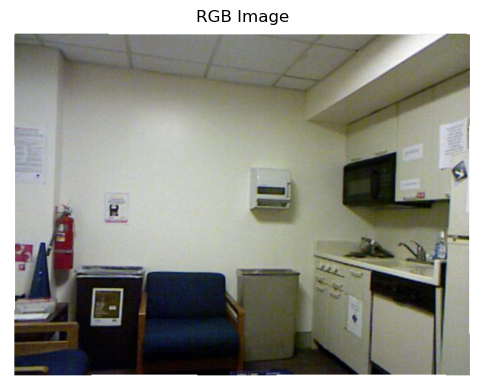

In [32]:
import matplotlib.pyplot as plt

rgb_hwc = np.transpose(rgb, (2, 1, 0))


plt.figure(figsize=(6,6))
plt.imshow(rgb_hwc.astype(np.uint8))
plt.title("RGB Image")
plt.axis('off')
plt.show()


In [33]:
label.shape

(640, 480)

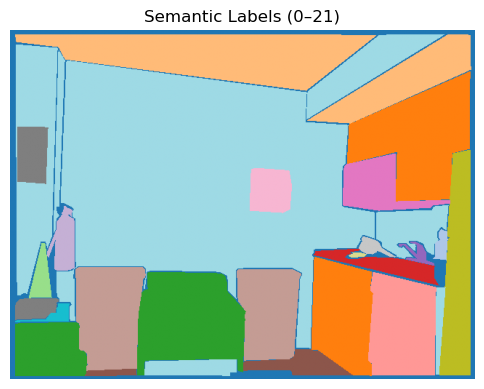

In [ ]:
import matplotlib.pyplot as plt


# label_t = np.transpose(label, (2, 1, 0))

plt.figure(figsize=(6,6))
plt.imshow(label.T, cmap='tab20')  # categorical colormap for 20+ classes
# plt.colorbar()
plt.title("Semantic Labels (0–21)")
plt.axis('off')
plt.show()


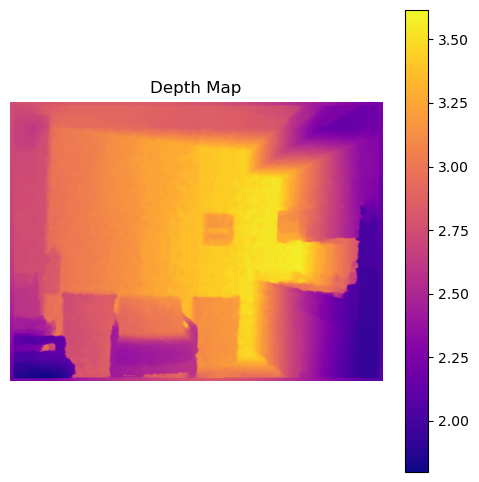

In [35]:
plt.figure(figsize=(6,6))
plt.imshow(depth.T, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.axis('off')
plt.show()

In [36]:
# visualize or see the numbers on the image to see how each class is represented
